In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import calendar
from sklearn.linear_model import LinearRegression
import scipy.signal as signal

In [2]:
import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages("peso.pdf")

In [3]:
df = pd.read_csv("./data/SWT_EXPORT_11_15_20_13_40.csv",
                 parse_dates=["Date"],
                 dtype={"Date":"str", "Weight":"float"})
df.head()

,Date,Weight
0,2017-11-13,76.1
1,2017-11-14,76.2
2,2017-11-15,76.6
3,2017-11-16,77.1
4,2017-11-17,76.7


In [4]:
df["Year"] = pd.DatetimeIndex(df["Date"]).year
df["Month"] = pd.DatetimeIndex(df["Date"]).month
df["Day"] = pd.DatetimeIndex(df["Date"]).day
df["Week"] = pd.DatetimeIndex(df["Date"]).week
df["DayOfWeek"] = pd.DatetimeIndex(df["Date"]).dayofweek
df.head()

,Date,Weight,Year,Month,Day,Week,DayOfWeek
0,2017-11-13,76.1,2017,11,13,46,0
1,2017-11-14,76.2,2017,11,14,46,1
2,2017-11-15,76.6,2017,11,15,46,2
3,2017-11-16,77.1,2017,11,16,46,3
4,2017-11-17,76.7,2017,11,17,46,4


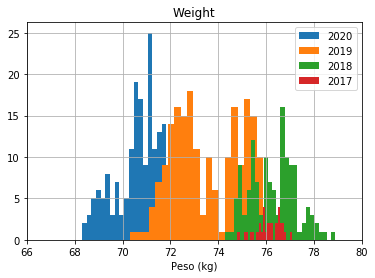

In [5]:
fig, ax = plt.subplots()
df[df["Year"] == 2020].hist(column="Weight", bins=26, ax=ax, label = "2020")
df[df["Year"] == 2019].hist(column="Weight", bins=26, ax=ax, label = "2019")
df[df["Year"] == 2018].hist(column="Weight", bins=26, ax=ax, label = "2018")
df[df["Year"] == 2017].hist(column="Weight", bins=26, ax=ax, label = "2017")
plt.xlim(66,80)
plt.xlabel("Peso (kg)")
plt.legend()
plt.show()
pdf.savefig(fig)

In [6]:
df_year = df[["Year","Weight"]].groupby(["Year"]).count()
df_year.columns = ["count"]
df_year["mean"] = df[["Year","Weight"]].groupby(["Year"]).mean()
df_year["var"] = df[["Year","Weight"]].groupby(["Year"]).var()
df_year["std"] = df[["Year","Weight"]].groupby(["Year"]).std()
df_year = df_year.reset_index()
df_year["Date"] = pd.to_datetime(df_year["Year"].map('{:04}-07-01'.format), format='%Y-%m-%d')
df_year

,Year,count,mean,var,std,Date
0,2017,32,76.090625,0.284103,0.533013,2017-07-01
1,2018,132,76.287121,0.915024,0.956569,2018-07-01
2,2019,209,73.746890,2.422887,1.556563,2019-07-01
3,2020,201,70.853731,1.154099,1.074290,2020-07-01


In [7]:
df_month = df[["Year","Month","Weight"]].groupby(["Year","Month"]).count()
df_month.columns = ["count"]
df_month["mean"] = df[["Year","Month","Weight"]].groupby(["Year","Month"]).mean()
df_month["var"] = df[["Year","Month","Weight"]].groupby(["Year","Month"]).var()
df_month["std"] = df[["Year","Month","Weight"]].groupby(["Year","Month"]).std()
df_month = df_month.reset_index()
df_month["YearMonth"] = df_month["Year"].map('{:04}'.format) + "-" +df_month["Month"].map('{:02}'.format)
df_month["Date"] = pd.to_datetime(df_month["Year"].map('{:04}'.format) + "-" 
                                 + df_month["Month"].map('{:02}'.format) + "-15", format='%Y-%m-%d')
df_month.head()

,Year,Month,count,mean,var,std,YearMonth,Date
0,2017,11,16,76.468750,0.082292,0.286865,2017-11,2017-11-15
1,2017,12,16,75.712500,0.199833,0.447027,2017-12,2017-12-15
2,2018,1,14,76.564286,0.228626,0.478149,2018-01,2018-01-15
3,2018,2,18,76.716667,0.273235,0.522719,2018-02,2018-02-15
4,2018,3,14,76.871429,0.248352,0.498349,2018-03,2018-03-15


In [8]:
df_week = df[["Year","Week","Weight"]].groupby(["Year","Week"]).count()
df_week.columns = ["count"]
df_week["mean"] = df[["Year","Week","Weight"]].groupby(["Year","Week"]).mean()
df_week["var"] = df[["Year","Week","Weight"]].groupby(["Year","Week"]).var()
df_week["std"] = df[["Year","Week","Weight"]].groupby(["Year","Week"]).std()
df_week = df_week.reset_index()
df_week["YearWeek"] = df_week["Year"].map('{:04}'.format) + "-" +df_week["Week"].map('{:02}'.format)
df_week["Date"] = df_week["Year"].map('{:04}'.format) + "-W" + df_week["Week"].map('{:02}'.format) + "-04"
df_week["Date"] = df_week["Date"].apply(lambda x: datetime.datetime.strptime(x, '%Y-W%W-0%w'))
df_week["Date"] = pd.to_datetime(df_week["Date"], format='%Y-%m-%d')
df_week.head()

,Year,Week,count,mean,var,std,YearWeek,Date
0,2017,46,7,76.471429,0.175714,0.419183,2017-46,2017-11-16
1,2017,47,6,76.516667,0.021667,0.147196,2017-47,2017-11-23
2,2017,48,6,76.083333,0.113667,0.337145,2017-48,2017-11-30
3,2017,49,4,75.425000,0.215833,0.464579,2017-49,2017-12-07
4,2017,50,5,75.740000,0.373000,0.610737,2017-50,2017-12-14


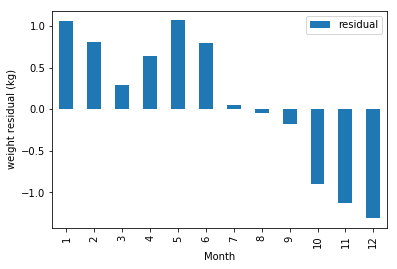

In [9]:
df_yearmonth_weight = pd.merge(df_month[["Year","Month","mean"]].rename(columns={"mean":"mean_month"}),
                        df_year[["Year","mean"]].rename(columns={"mean":"mean_year"}),
                        how='left',on="Year",validate="m:1")
df_yearmonth_weight["residual"] = df_yearmonth_weight["mean_month"] - df_yearmonth_weight["mean_year"]
fig, ax = plt.subplots()
df_yearmonth_weight[["Month","residual"]].groupby(["Month"]).mean().plot.bar(ax=ax)
plt.ylabel("weight residual (kg)")
plt.show()
pdf.savefig(fig)

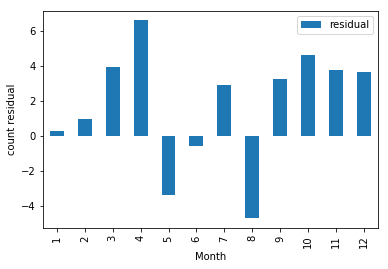

In [10]:
df_yearmonth_count = pd.merge(df_month[["Year","Month","count"]].rename(columns={"count":"count_month"}),
                        df_year[["Year","count"]].rename(columns={"count":"count_year"}),
                        how='left',on="Year",validate="m:1")
df_yearmonth_count["residual"] = df_yearmonth_count["count_month"] - df_yearmonth_count["count_year"]/12.
fig, ax = plt.subplots()
df_yearmonth_count[["Month","residual"]].groupby(["Month"]).mean().plot.bar(ax=ax)
plt.ylabel("count residual")
plt.show()
pdf.savefig(fig)

In [11]:
df_yearmonth = pd.merge(df_yearmonth_weight[["Month","residual"]].rename(columns={"residual":"res_weight"}).groupby(["Month"]).mean(),
                        df_yearmonth_count[["Month","residual"]].rename(columns={"residual":"res_count"}).groupby(["Month"]).mean(),
                        on="Month",validate="1:1")

In [12]:
model_ym = LinearRegression()
x = df_yearmonth.iloc[:, 0].values.reshape(-1, 1)
y = df_yearmonth.iloc[:, 1].values.reshape(-1, 1)
model_ym.fit(x,y)
fy = model_ym.predict(x)

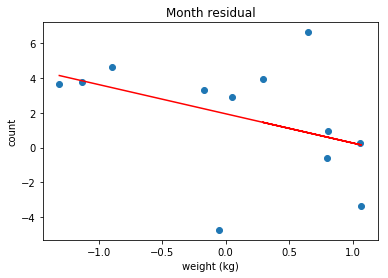

In [13]:
fig, ax = plt.subplots()
plt.scatter(x,y)
plt.plot(x, fy, color='red')
plt.title("Month residual")
plt.ylabel("count")
plt.xlabel("weight (kg)")
plt.show()
pdf.savefig(fig)

In [14]:
df_yearmonth.corr(method='pearson')

,res_weight,res_count
res_weight,1.000000,-0.419013
res_count,-0.419013,1.000000


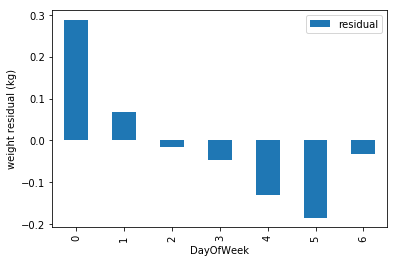

In [15]:
df["YearWeek"] = df["Year"].map('{:04}'.format) + "-" + df["Week"].map('{:02}'.format)
df_weekday_weight = pd.merge(df[["YearWeek","DayOfWeek","Weight"]],
                        df_week[["YearWeek","mean"]],
                        how='left',on="YearWeek",validate="m:1")
df_weekday_weight["residual"] = df_weekday_weight["Weight"] - df_weekday_weight["mean"]
fig, ax = plt.subplots()
df_weekday_weight[["DayOfWeek", "residual"]].groupby(["DayOfWeek"]).mean().plot.bar(ax=ax)
plt.ylabel("weight residual (kg)")
plt.show()
pdf.savefig(fig)

In [16]:
df["count"] = [1 for i in range(len(df["Weight"]))]
dates = pd.date_range(min(df['Date']),max(df['Date']),freq='d')
df_day = pd.DataFrame()
df_day["Date"] = dates
df_day = pd.merge(df_day, df[["Date","count"]], how='left',on="Date",validate="1:m")
df_day["count"] = df_day["count"].fillna(0)
df_day["Year"] = pd.DatetimeIndex(df_day["Date"]).year
df_day["Month"] = pd.DatetimeIndex(df_day["Date"]).month
df_day["Day"] = pd.DatetimeIndex(df_day["Date"]).day
df_day["Week"] = pd.DatetimeIndex(df_day["Date"]).week
df_day["DayOfWeek"] = pd.DatetimeIndex(df_day["Date"]).dayofweek
df_day["YearWeek"] = df_day["Year"].map('{:04}'.format) + "-" + df_day["Week"].map('{:02}'.format)
df_day.head()

,Date,count,Year,Month,Day,Week,DayOfWeek,YearWeek
0,2017-11-13,1.0,2017,11,13,46,0,2017-46
1,2017-11-14,1.0,2017,11,14,46,1,2017-46
2,2017-11-15,1.0,2017,11,15,46,2,2017-46
3,2017-11-16,1.0,2017,11,16,46,3,2017-46
4,2017-11-17,1.0,2017,11,17,46,4,2017-46


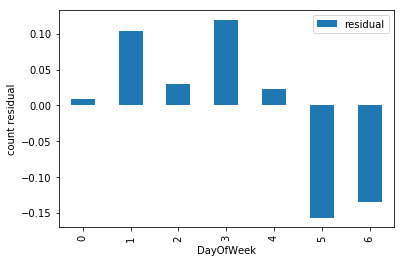

In [17]:
df_weekday_count = pd.merge(df_day[["YearWeek","DayOfWeek","count"]].rename(columns={"count":"count_day"}),
                        df_week[["YearWeek","count"]].rename(columns={"count":"count_week"}),
                        how='left',on="YearWeek",validate="m:1")
df_weekday_count["residual"] = df_weekday_count["count_day"] - df_weekday_count["count_week"]/7.
fig, ax = plt.subplots()
df_weekday_count[["DayOfWeek", "residual"]].groupby(["DayOfWeek"]).mean().plot.bar(ax=ax)
plt.ylabel("count residual")
plt.show()
pdf.savefig(fig)

In [18]:
df_weekday = pd.merge(df_weekday_weight[["DayOfWeek","residual"]].rename(columns={"residual":"res_weight"}).groupby(["DayOfWeek"]).mean(),
                        df_weekday_count[["DayOfWeek","residual"]].rename(columns={"residual":"res_count"}).groupby(["DayOfWeek"]).mean(),
                        on="DayOfWeek",validate="1:1")

In [19]:
model_wd = LinearRegression()
x = df_weekday.iloc[:, 0].values.reshape(-1, 1)
y = df_weekday.iloc[:, 1].values.reshape(-1, 1)
model_wd.fit(x,y)
fy = model_wd.predict(x)

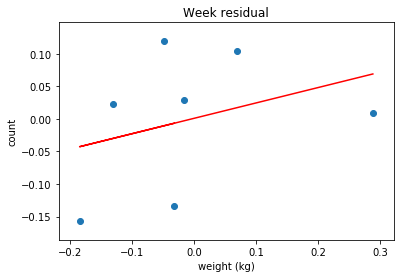

,res_weight,res_count
DayOfWeek,,
0,0.287986,0.008593
1,0.068832,0.104478
2,-0.016697,0.029630
3,-0.047692,0.119403
4,-0.130980,0.022388
5,-0.184024,-0.156716
6,-0.031648,-0.134328


In [20]:
fig, ax = plt.subplots()
plt.scatter(x,y)
plt.plot(x,fy,color='red')
plt.title("Week residual")
plt.ylabel("count")
plt.xlabel("weight (kg)")
plt.show()
pdf.savefig(fig)
df_weekday

In [21]:
df_weekday.corr(method='pearson')

,res_weight,res_count
res_weight,1.000000,0.338944
res_count,0.338944,1.000000


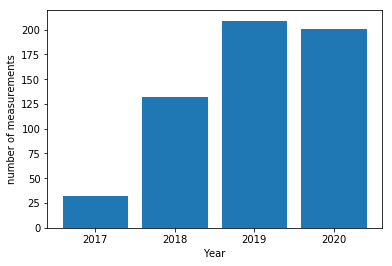

In [22]:
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.bar(x=df_year["Date"],height=df_year["count"],width=300, align='center')
ax.xaxis.set_ticks(df_year["Date"])
plt.xlabel("Year")
plt.ylabel("number of measurements")
plt.show()
pdf.savefig(fig)

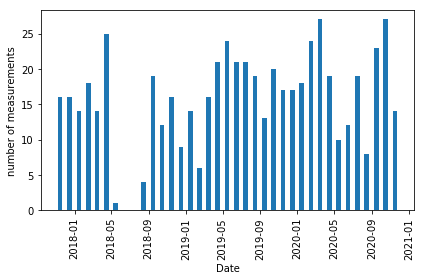

In [23]:
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax.bar(x=df_month["Date"],height=df_month["count"],width=15, align='center')
plt.xlabel("Date")
plt.ylabel("number of measurements")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
#pdf.savefig(fig)

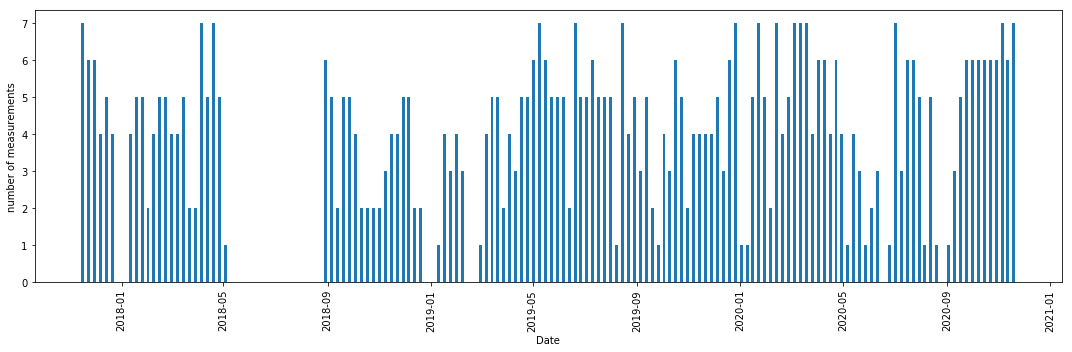

In [24]:
fig, ax = plt.subplots(figsize=(15,5))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax.bar(x=df_week["Date"],height=df_week["count"],width=3.5, align='center')
plt.xlabel("Date")
plt.ylabel("number of measurements")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
#pdf.savefig(fig)

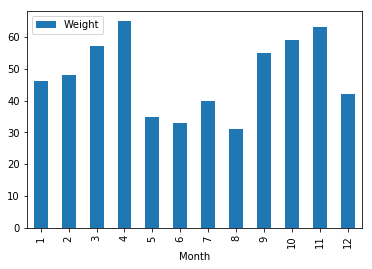

In [25]:
fig, ax = plt.subplots()
df[["Month","Weight"]].groupby(["Month"]).count().plot.bar(ax=ax)
plt.show()
pdf.savefig(fig)

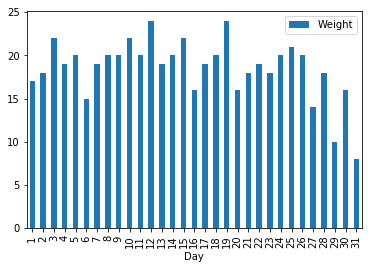

In [26]:
fig, ax = plt.subplots()
df[["Day","Weight"]].groupby(["Day"]).count().plot.bar(ax=ax)
plt.show()
pdf.savefig(fig)

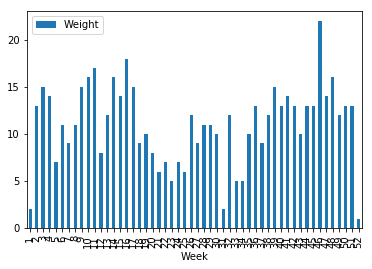

In [27]:
fig, ax = plt.subplots()
df[["Week","Weight"]].groupby(["Week"]).count().plot.bar(ax=ax)
plt.show()
pdf.savefig(fig)

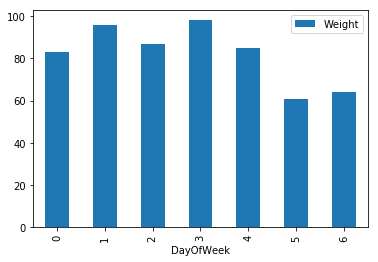

In [28]:
fig, ax = plt.subplots()
df[["DayOfWeek","Weight"]].groupby(["DayOfWeek"]).count().plot.bar(ax=ax)
plt.show()
pdf.savefig(fig)

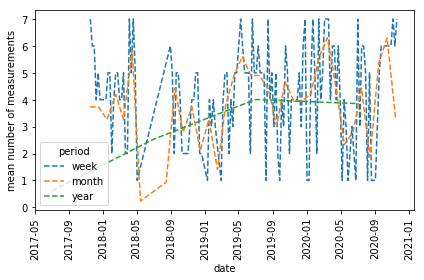

In [29]:
fig, ax = plt.subplots()
plt.plot(df_week["Date"],df_week["count"],"--",label="week")
plt.plot(df_month["Date"],df_month["count"]/30*7,"--",label="month")
plt.plot(df_year["Date"],df_year["count"]/365*7,"--",label="year")
plt.xticks(rotation=90)
plt.legend(title="period")
plt.xlabel("date")
plt.ylabel("mean number of measurements")
plt.tight_layout()
plt.show()
pdf.savefig(fig)

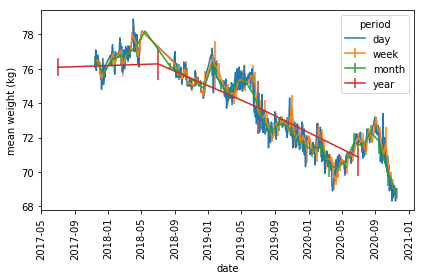

In [30]:
fig, ax = plt.subplots()
plt.errorbar(x=df["Date"],y=df["Weight"],label="day")
plt.errorbar(x=df_week["Date"],y=df_week["mean"],yerr=df_week["std"],label="week")
plt.errorbar(x=df_month["Date"],y=df_month["mean"],yerr=df_month["std"],label="month")
plt.errorbar(x=df_year["Date"],y=df_year["mean"],yerr=df_year["std"],label="year")
plt.xticks(rotation=90)
plt.legend(title="period")
plt.xlabel("date")
plt.ylabel("mean weight (kg)")
plt.tight_layout()
plt.show()
pdf.savefig(fig)

In [31]:
x = df["Date"].astype(int)/(1.E9*60*60*24)
y = df.iloc[:,1]
f = 10**np.linspace(np.log10(1/400), 0, 10000)
pgram = signal.lombscargle(x, y, f, normalize=False)

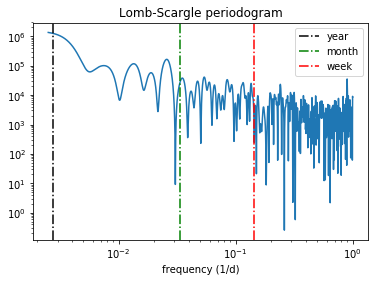

In [32]:
fig, ax = plt.subplots()
plt.plot(f, pgram)
plt.axvline(x=1/365, color='black', label="year",linestyle='-.')
plt.axvline(x=1/30, color='g', label="month",linestyle='-.')
plt.axvline(x=1/7, color='r', label="week",linestyle='-.')
plt.yscale("log")
plt.xscale("log")
plt.xlabel("frequency (1/d)")
plt.title("Lomb-Scargle periodogram")
plt.legend()
plt.show()
pdf.savefig(fig)

In [33]:
pdf.close()